http://library.jsce.or.jp/jsce/open/00039/201506_no51/pdf/400.pdf

ここの再現を行う．

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import rich.traceback

In [2]:
rich.traceback.install(show_locals=True)
from pathlib import Path
import os

if (pwd := Path.cwd()).stem == 'test':
    os.chdir(pwd.parent)

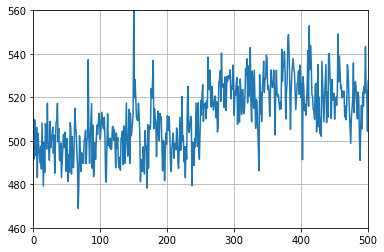

In [3]:
# dataset 1 の作成
def make_dataset_1():
    r"""ARMA モデルにしたがって時系列データ $x_t$ を発生させる．

    $$
    z_t = \alpha z_{t-1} + \epsilon_t + \beta \epsilon_{t-1}
    \\
    x_t = z_t + \mu_t
    $$

    ただし $z_0 = 0, \epsilon_0 = 0$ とした．

    Returns
    -------
    x_t: 長さ 501 の信号
    """
    def get_mu(time):
        if time == 150:
            return 535
        if time > 250:
            return 520
        else:
            return 500

    T = 501
    x = np.zeros(T)
    z_t = 0.0
    eps_t = np.random.normal(0, 10)
    alpha = 0.8
    beta = -0.6

    # if t = 0
    z_t = eps_t
    x[0] = z_t + get_mu(0)
    # otherwise
    for t in range(1, T):
        z_t = alpha * z_t
        z_t += beta * eps_t
        eps_t = np.random.normal(0, 10)
        z_t += eps_t

        x[t] = z_t + get_mu(t)

    return x

data1 = make_dataset_1()

plt.plot(data1)
plt.ylim(460, 560)
plt.xlim(0, 500)
plt.grid()
plt.show()

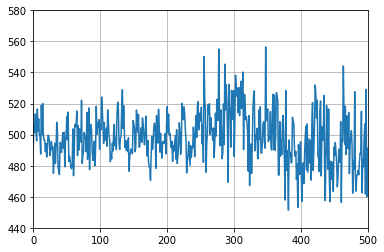

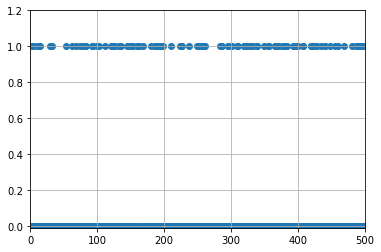

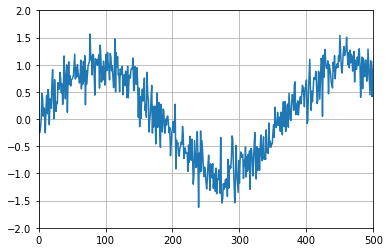

In [4]:
# dataset 2 の作成
def make_dataset_2():
    r"""ARMAX モデルにしたがって時系列データ $x_t$ を発生させる．

    $$
    z_t = \alpha z_{t-1} + \epsilon_t + \beta \epsilon_{t-1}
    \\
    x_t = z_t + \mu + \gamma_1 \xi_{1t} + \gamma_2 \xi_{2t}
    $$

    Returns
    -------
    x: 長さ 501 の信号
    xi_1: 1 つ目の外生変数 (0 or 1)
    xi_2: 2 つ目の外生変数
    """
    def get_sigma(t):
        if t > 250:
            return 20
        else:
            return 10

    T = 501
    x = np.zeros(T)
    mu = 500
    alpha = 0.8
    beta = -0.6
    gamma_1 = 6.0
    gamma_2 = -4.0

    xi_1 = stats.bernoulli.rvs(0.2, size=T)
    xi_2 = np.sin(0.017 * np.arange(T)) + np.random.normal(0, 0.25, size=T)

    # if t = 0
    eps_t = np.random.normal(0, get_sigma(0))
    z_t = eps_t
    x[0] = z_t + mu + gamma_1 * xi_1[0] + gamma_2 * xi_2[0]
    # otherwise
    for t in range(1, T):
        z_t = alpha * z_t
        z_t += beta * eps_t
        eps_t = np.random.normal(0, get_sigma(t))
        z_t += eps_t

        x[t] = z_t + mu + gamma_1 * xi_1[t] + gamma_2 * xi_2[t]

    return x, xi_1, xi_2

data2, xi1, xi2 = make_dataset_2()
plt.plot(data2)
plt.xlim(0, 500)
plt.ylim(440, 580)
plt.grid()
plt.show()
plt.scatter(np.arange(len(xi1)), xi1)
plt.xlim(0, 500)
plt.ylim(-0.01, 1.2)
plt.grid()
plt.show()
plt.plot(xi2)
plt.xlim(0, 500)
plt.ylim(-2, 2)
plt.grid()
plt.show()

作成した ARMAX が正常に動作するか確認する．

In [5]:
from changefinder import ARMAXusingSMC

C:\Users\siitake\miniconda3\envs\dev_changefinder\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [6]:
# data1 のモデルの確認...
model = ARMAXusingSMC(p=1, q=1, M=0, n_particle=100)

In [11]:
w[0]

{'mu': 0.0,
 'sigma': 0.0,
 'sigma_w': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'alpha_0': 0.0,
 'beta_0': 0.0}

In [7]:
# 逐次的な学習と予測
p = list()
w = list()
l = list()
for x in tqdm(data1):
    pp = model.predict()
    p.append(pp)
    ll, ww = model.update(x)
    l.append(ll)
    w.append(ww)
p = np.array(p)
l = np.array(l)

  0%|          | 0/501 [00:00<?, ?it/s]c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:192: RuntimeWarning: divide by zero encountered in log
  self.__mu['weights'] = np.exp(np.log(self.__mu['weights']) + np.log(mu_w))
c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:195: RuntimeWarning: divide by zero encountered in log
  np.log(self.__alpha[i]['weights']) + np.log(alpha_w[i])
c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:199: RuntimeWarning: divide by zero encountered in log
  np.log(self.__beta[i]['weights']) + np.log(beta_w[i])
c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:205: RuntimeWarning: divide by zero encountered in log
  self.__sigma['weights'] = np.exp(np.log(self.__sigma['weights']) + np.log(sigma_w))
c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:274: RuntimeWarning: divide by zero encountered in log
  return - np.log(np.sum(weight)), weights
 

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ C:\Users\siitake\AppData\Local\Temp/ipykernel_25840/1301324003.py:6 in <module>           │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ 'C:\\Users\\siitake\\AppData\\Local\\Temp/ipykernel_25840/1301324003.py'                  │
│ c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:131 in predict   │
│                                                                                           │
│   128 │   │   if eps is None:                                                             │
│   129 │   │   │   eps = self.__model.predict(                                             │
│   130 │   │   │   │   0,                                                                  │
│ ❱ 131 │   │   │   │   self.__term(self.__sigma, False),                                   │
│   132 │   │   │   │   size=1,                                                             │
│   133 │   │   │   )                                                                       │
│   134 │   │   return self.__predict(eps, '', None, exog)                                  │
│                                                                                           │
│ ╭────────────────────────────────── locals ──────────────────────────────────╮            │
│ │  eps = None                                                                │            │
│ │ exog = None                                                                │            │
│ │ self = <changefinder.armax_smc.ARMAXusingSMC object at 0x000001E68A6897C0> │            │
│ ╰────────────────────────────────────────────────────────────────────────────╯            │
│                                                                                           │
│ c:\Users\siitake\Documents\GitHub\changefinder\changefinder\armax_smc.py:91 in __term     │
│                                                                                           │
│    88 │   │   if is_particle:                                                             │
│    89 │   │   │   return param['values']                                                  │
│    90 │   │   else:                                                                       │
│ ❱  91 │   │   │   return np.average(param['values'], weights=param['weights'])            │
│    92 │                                                                                   │
│    93 │   def __predict(self, eps, p_name, p_idx=None, exog=None):                        │
│    94 │   │   """predict \hat{x}_t from parametes.                                        │
│                                                                                           │
│ ╭─────────────────────────────────────── locals ────────────────────────────────────────╮ │
│ │ is_particle = False                                                                   │ │
│ │       param = {                                                                       │ │
│ │               │   'values': array([4.38774051, 6.74422242, 2.07739292, 1.42848976,    │ │
│ │               1.01137578,                                                             │ │
│ │               │      0.41370698, 0.95551359, 0.02798899, 0.97602809, 0.47067494,      │ │
│ │               │      1.71126725, 1.57001982, 0.47371703, 3.07024293, 0.69999469,      │ │
│ │               │      0.4260152 , 0.29343501, 1.89390225, 0.17927787, 1.52311758,      │ │
│ │               │      1.56808373, 0.16411325, 0.91362273, 2.22481968, 1.08715475,      │ │
│ │               │      0.21564226, 0.55090806, 1.18334594, 0.1936574 , 2.8464211 ,      │ │
│ │               │      1.46007451, 0.49300603, 2.7

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ C:\Users\siitake\AppData\Local\Temp/ipykernel_25840/1595372957.py:7 in <module>           │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ 'C:\\Users\\siitake\\AppData\\Local\\Temp/ipykernel_25840/1595372957.py'                  │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'reshape'

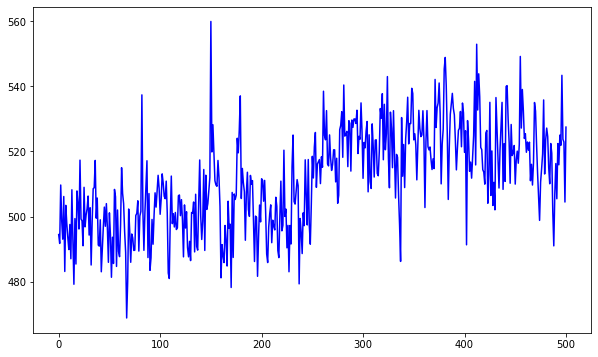

In [8]:
#data1.shape
#p.shape
#l.shape
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(data1)), data1, color='blue', label='true')
ax.plot(np.arange(len(p)), p.reshape(-1), color='red', label='pred')
plt.legend()
plt.show()

<AxesSubplot:>

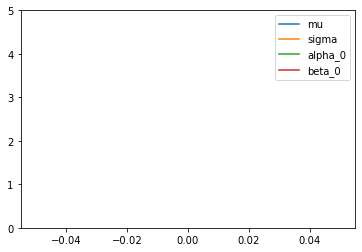

In [9]:
pd.DataFrame(w).plot(ylim=(0, 5))